# Learn how to use cython

Source from http://consulting.behnel.de/ and https://www.youtube.com/watch?v=vl9La7wH7QI

In [1]:
%load_ext cython

In [5]:
import sys
import Cython
import numpy as np

print("Python %d.%d.%d %s %s" % sys.version_info)
print("Cython %s" % Cython.__version__)
print("NumPy  %s" % np.__version__)

Python 3.9.13 final 0
Cython 0.29.33
NumPy  1.21.5


## Cython Intro

### using Python:

In [6]:
from math import sin
sin(5)

-0.9589242746631385

### using Cython:

In [ ]:
%load_ext cython

In [12]:
%%cython
from math import sin
sin(5)

In [9]:
sin(5)

-0.9589242746631385

or, use "libc.math" from C instead of "math" from Python

In [8]:
%%cython
cimport libc.math
sin_func = libc.math.sin

In [10]:
sin_func(5)

-0.9589242746631385

or,

In [13]:
%%cython
cimport libc.math

def csin(double x):
    return libc.math.sin(x)

In [14]:
csin(5)

-0.9589242746631385

## Show Cython’s code analysis

by passing the '--annotate' option(or just '-a'):

In [15]:
%%cython -a
cimport libc.math

def csin(double x):
    return libc.math.sin(x)

This produces an HTML report of Cython code interleaved with the generated C code. Lines are colored according to the level of “typedness” – white lines translate to pure C, while lines that require the Python C-API are yellow (darker as they translate to more C-API interaction). Lines that translate to C code have a plus (+) in front and can be clicked to show the generated code.

This report is invaluable when optimizing a function for speed, and for determining when to release the GIL: in general, a nogil block may contain only “white” code.

In [16]:
%%cython --annotate
cimport libc.math

def square_sin(double x):
    cdef double x_square = x * x
    return libc.math.sin(x_square)

In [17]:
square_sin(5)

-0.13235175009777303

## Examples

### Create some data to use for this example

In [18]:
people = 44_000_000
average = 3703*12
print("Average income of {:,d} earners, Deutschland 2016: {:,d} €".format(people, average))

Average income of 44,000,000 earners, Deutschland 2016: 44,436 €


lacking offical data, let's create some alternative facts
Draw samples from a log-normal distribution. Mean value 'mu' of the underlying normal distribution is 10.64, standard deviation 'sigma' of the underlying normal distribution is 0.35, and size is people // 20.

In [24]:
# lacking offical data, let's create some alternative facts
import numpy as np
mu, sigma = 10.64, .35
samples = np.random.lognormal(mu, sigma, people // 20)
['{:,.2f} €'.format(x) for x in (np.min(samples), np.mean(samples), np.max(samples))]

['7,075.37 €', '44,421.90 €', '216,314.02 €']

Present these data in the figure:

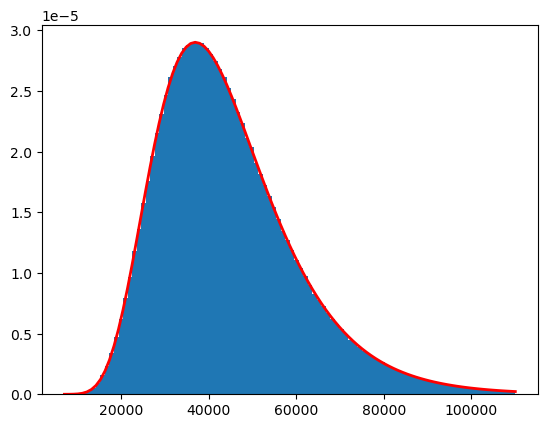

In [25]:
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(samples[samples < 110000], 100, density=True, align='mid')
x = np.linspace(min(bins), max(bins), 101)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(bins, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.show()

### Operative part

Let's calculate everyone's taxes.(https://de.wikipedia.org/wiki/Einkommensteuer_%28Deutschland%29#Tarif_2017)

In [23]:
# from Wikipedia:
# =WENN(A1>256303; A1*0,45-16164,53;
#  WENN(A1>54057; A1*0,42-8475,44;
#  WENN(A1>13769; (A1-13769)*((A1-13769)*0,0000022376+0,2397)+939,57;
#  WENN(A1>8820; (A1-8820)*((A1-8820)*0,0000100727+0,14); 0))))

def calculate_tax(income):
    if income > 256303:
        return income * 0.45 - 16164.53
    elif income > 54057:
        return income * 0.42 - 8475.44
    elif income > 13769:
        return (income - 13769) * ((income - 13769) * 0.0000022376 + 0.2397) + 939.57
    elif income > 8820:
        return (income - 8820) * ((income - 8820) * 0.0000100727 + 0.14)
    else:
        return 0

def average_income(incomes):
    return sum(incomes) / len(incomes)

def average_tax_rate(incomes):
    return sum(calculate_tax(x) for x in incomes) / sum(incomes)

average income and tax are:

In [27]:
average, calculate_tax(average)

(44436, 10394.834135626399)

average income and average tax are:

In [28]:
incomes_np = samples
incomes = list(samples)

avg_in, avg_tax = average_income(incomes), average_tax_rate(incomes)
avg_in, avg_tax

(44421.90256771482, 0.24290608306517872)

In [29]:
%%timeit
average_tax_rate(incomes)

3.31 s ± 113 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Here we record the execution time of python, and create ratios function to compare the results afterwards

In [30]:
Tpython = 3.31

In [31]:
import operator

timings = {}

def ratios(**new):
    assert len(new) == 1
    timings.update(**new)
    last = list(new.values())[0]
    print('\n'.join('%10s: %7.2f' % (name, t / last)
                    for name, t in sorted(timings.items(), key=operator.itemgetter(1))))

ratios(python=Tpython)

    python:    1.00


### Numpy slicing

Let's use the following code instead of the above section.

In [32]:
# from Wikipedia:
# =WENN(A1>256303; A1*0,45-16164,53;
#  WENN(A1>54057; A1*0,42-8475,44;
#  WENN(A1>13769; (A1-13769)*((A1-13769)*0,0000022376+0,2397)+939,57;
#  WENN(A1>8820; (A1-8820)*((A1-8820)*0,0000100727+0,14); 0))))

def calculate_tax_numpy_segments(d):
    tax_seg1 = d[(d > 256303)] * 0.45 - 16164.53
    tax_seg2 = d[(d > 54057) & (d <= 256303)] * 0.42 - 8475.44
    seg3 = d[(d > 13769) & (d <= 54057)] - 13769
    seg4 = d[(d > 8820) & (d <= 13769)] - 8820
    prog_seg3 = seg3 * 0.0000022376 + 0.2397
    prog_seg4 = seg4 * 0.0000100727 + 0.14
    return (
        tax_seg1.sum() +
        tax_seg2.sum() +
        (seg3 * prog_seg3 + 939.57).sum() +
        (seg4 * prog_seg4).sum()
    ) / d.sum()

average income and average tax are:

In [33]:
incomes_np.mean(), calculate_tax_numpy_segments(incomes_np)

(44421.9025677147, 0.24290608306519038)

In [34]:
%%timeit
calculate_tax_numpy_segments(incomes_np)

79.4 ms ± 5.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
ratios(numpy=0.0794)

     numpy:    1.00
    python:   41.69


### NumPy ufunc

In [36]:
calculate_tax_numpy = np.frompyfunc(calculate_tax, 1, 1)

average tax is:

In [37]:
calculate_tax_numpy(incomes_np).sum() / incomes_np.sum()

0.24290608306517936

In [38]:
%%timeit
calculate_tax_numpy(incomes_np).sum() / incomes_np.sum()

911 ms ± 55.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
ratios(ufunc=0.911)

     numpy:    0.09
     ufunc:    1.00
    python:    3.63


### Cython

In [46]:
%%cython -a
# plain copy from Python code above, only renamed functions

def calculate_tax_cy(income):
    if income > 256303:
        return income * 0.45 - 16164.53
    elif income > 54057:
        return income * 0.42 - 8475.44
    elif income > 13769:
        return (income - 13769) * ((income - 13769) * 0.0000022376 + 0.2397) + 939.57
    elif income > 8820:
        return (income - 8820) * ((income - 8820) * 0.0000100727 + 0.14)
    else:
        return 0

def average_income_cy(incomes):
    return sum(incomes) / len(incomes)

def average_tax_rate_cy(incomes):
    return sum(calculate_tax_cy(x) for x in incomes) / sum(incomes)

average income and average tax are:

In [41]:
average_income_cy(incomes), average_tax_rate_cy(incomes)

(44421.90256771482, 0.24290608306517872)

In [42]:
%%timeit
average_tax_rate_cy(incomes)

2.75 s ± 49.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
ratios(cython_copy=2.75)

     numpy:    0.03
     ufunc:    0.33
cython_copy:    1.00
    python:    1.20


### Faster Cython: static types

In [51]:
%%cython -a
# plain copy from Python code above, only renamed functions

cpdef double calculate_tax_cy(double income):
    if income > 256303:
        return income * 0.45 - 16164.53
    elif income > 54057:
        return income * 0.42 - 8475.44
    elif income > 13769:
        return (income - 13769) * ((income - 13769) * 0.0000022376 + 0.2397) + 939.57
    elif income > 8820:
        return (income - 8820) * ((income - 8820) * 0.0000100727 + 0.14)
    else:
        return 0

def average_income_cy(incomes):
    return sum(incomes) / len(incomes)

def average_tax_rate_cy(list incomes not None):
    cdef double tax_sum = 0, total = 0, income
    for income in incomes:
        tax_sum += calculate_tax_cy(income)
        total += income
    return tax_sum / total

In [52]:
average_tax_rate_cy(incomes)

0.24290608306517872

In [53]:
%%timeit
average_tax_rate_cy(incomes)

32.6 ms ± 804 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [54]:
ratios(cython_typed=0.0326)

cython_typed:    1.00
     numpy:    2.44
     ufunc:   27.94
cython_copy:   84.36
    python:  101.53


In [56]:
%%cython -a
# plain copy from Python code above, only renamed functions

cpdef double calculate_tax_cys(double income):
    if income > 256303:
        return income * 0.45 - 16164.53
    elif income > 54057:
        return income * 0.42 - 8475.44
    elif income > 13769:
        return (income - 13769) * ((income - 13769) * 0.0000022376 + 0.2397) + 939.57
    elif income > 8820:
        return (income - 8820) * ((income - 8820) * 0.0000100727 + 0.14)
    else:
        return 0

def average_tax_rate_cys(list incomes not None):
    cdef double tax = 0, income = 0, x
    for x in incomes:
        income += x
        tax += calculate_tax_cys(x)
    return tax / income

In [57]:
average_tax_rate_cys(incomes)

0.24290608306517872

In [58]:
%%timeit
average_tax_rate_cys(incomes)

31.4 ms ± 416 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [59]:
ratios(cython_typed=0.0314)

cython_typed:    1.00
     numpy:    2.53
     ufunc:   29.01
cython_copy:   87.58
    python:  105.41


## Exercise: static typing for speed

In [65]:
import math

def circular_distance(radius, lon1, lat1, lon2, lat2):
    x = math.pi/180.0
    a = (90.0-lat1) * x
    b = (90.0-lat2) * x
    theta = (lon2-lon1) * x
    c = math.acos((math.cos(a)*math.cos(b)) + (math.sin(a)*math.sin(b)*math.cos(theta)))
    return radius*c

print(circular_distance(10, 1.2, 2, 2, 4.3))

0.4249430879322785


In [66]:
%%timeit
circular_distance(10, 1.2, 2, 2, 4.3)

1.3 µs ± 46.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [75]:
%%cython -a
# copy and optimise ...
# hint: use "libc.math" from C instead of "math" from Python

cimport libc.math

cpdef double circular_distance_cy(double radius, double lon1, double lat1, double lon2, double lat2):
    cdef double x, a, b, theta, c
    x = libc.math.pi/180.0
    a = (90.0-lat1) * x
    b = (90.0-lat2) * x
    theta = (lon2-lon1) * x
    c = libc.math.acos((libc.math.cos(a)*libc.math.cos(b)) + (libc.math.sin(a)*libc.math.sin(b)*libc.math.cos(theta)))
    return radius*c

print(circular_distance_cy(10, 1.2, 2, 2, 4.3))

0.4249430879322785


In [76]:
%%timeit
circular_distance_cy(10, 1.2, 2, 2, 4.3)

227 ns ± 10.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


### Faster Cython: processing memory views

In [82]:
%%cython -a

cpdef double calculate_tax_memview(double income):
    if income > 256303:
        return income * 0.45 - 16164.53
    elif income > 54057:
        return income * 0.42 - 8475.44
    elif income > 13769:
        return (income - 13769) * ((income - 13769) * 0.0000022376 + 0.2397) + 939.57
    elif income > 8820:
        return (income - 8820) * ((income - 8820) * 0.0000100727 + 0.14)
    else:
        return 0

def average_tax_rate_memview(double[:] incomes):
    cdef double tax = 0, income = 0, x
    cdef size_t i
    for i in range(incomes.shape[0]):
        income += incomes[i]
        tax += calculate_tax_memview(incomes[i])
    return tax / income

In [79]:
average_tax_rate_memview(incomes_np)

0.24290608306517872

In [80]:
%%timeit
average_tax_rate_memview(incomes_np)

11.9 ms ± 647 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [87]:
ratios(mviews=0.0119)

    mviews:    1.00
cython_typed:    2.64
     numpy:    6.67
     ufunc:   76.55
cython_copy:  231.09
    python:  278.15


### bounds check

In [85]:
%%cython -a
cimport cython

cpdef double calculate_tax_memviewb(double income):
    if income > 256303:
        return income * 0.45 - 16164.53
    elif income > 54057:
        return income * 0.42 - 8475.44
    elif income > 13769:
        return (income - 13769) * ((income - 13769) * 0.0000022376 + 0.2397) + 939.57
    elif income > 8820:
        return (income - 8820) * ((income - 8820) * 0.0000100727 + 0.14)
    else:
        return 0

@cython.boundscheck(False)
def average_tax_rate_memviewb(double[:] incomes):
    cdef double tax = 0, income = 0, x
    cdef size_t i
    for i in range(incomes.shape[0]):
        income += incomes[i]
        tax += calculate_tax_memviewb(incomes[i])
    return tax / income

In [86]:
%%timeit
average_tax_rate_memviewb(incomes_np)

11.1 ms ± 312 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [89]:
ratios(mviews_bcheck=0.0111)

mviews_bcheck:    1.00
    mviews:    1.07
cython_typed:    2.83
     numpy:    7.15
     ufunc:   82.07
cython_copy:  247.75
    python:  298.20


### Faster Cython: prange

In [98]:
%%cython -f -c=/openmp
# distutils: extra_compile_args=-fopenmp
# distutils: extra_link_args=-fopenmp

# SOLUTION

cpdef double calculate_tax_cy(double income) nogil:
    if income > 256303:
        return income * 0.45 - 16164.53
    elif income > 54057:
        return income * 0.42 - 8475.44
    elif income > 13769:
        return (income - 13769) * ((income - 13769) * 0.0000022376 + 0.2397) + 939.57
    elif income > 8820:
        return (income - 8820) * ((income - 8820) * 0.0000100727 + 0.14)
    else:
        return 0

cimport cython
from cython.parallel cimport prange

@cython.boundscheck(False)
def average_tax_rate_prange(double[:] incomes):
    cdef unsigned long i
    cdef double tax = 0, income = 0, x
    for i in prange(incomes.shape[0], nogil=True, num_threads=4):
        x = incomes[i]
        income += x
        tax += calculate_tax_cy(x)
    return tax / income

In [99]:
average_tax_rate_prange(incomes_np)

0.24290608306519693

In [100]:
%%timeit
average_tax_rate_prange(incomes_np)

4.31 ms ± 95.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [101]:
ratios(prange=0.00431)

    prange:    1.00
mviews_bcheck:    2.58
    mviews:    2.76
cython_typed:    7.29
     numpy:   18.42
     ufunc:  211.37
cython_copy:  638.05
    python:  767.98


## more ...

In [ ]:
%%cython

cpdef double calculate_tax_cy(double income):
    if income > 256303:
        return income * 0.45 - 16164.53
    elif income > 54057:
        return income * 0.42 - 8475.44
    elif income > 13769:
        return (income - 13769) * ((income - 13769) * 0.0000022376 + 0.2397) + 939.57
    elif income > 8820:
        return (income - 8820) * ((income - 8820) * 0.0000100727 + 0.14)
    else:
        return 0

def average_tax_cy(incomes):
    # return sum(calculate_tax_cy(x) for x in incomes) / sum(incomes)
    cdef double tax = 0, income = 0, x
    for x in incomes:
        income += x
        tax += calculate_tax_cy(x)
    return tax / income


cimport numpy as cnp

def average_tax_numcy(cnp.ndarray[double, ndim=1] incomes):
    cdef long i
    cdef double tax = 0, income = 0, x
    for i in range(incomes.shape[0]):
        x = incomes[i]
        income += x
        tax += calculate_tax_cy(x)
    return income / tax


## Pythran integration

In [ ]:
%%cython
# cython: language=c++
# cython: np_pythran=True
# distutils: extra_compile_args=-std=c++11

import numpy as np
cimport numpy as cnp

def calculate_tax_numpy_segments(cnp.ndarray[double, ndim=1] d):
    tax_seg1 = d[(d > 256303)] * 0.45 - 16164.53
    tax_seg2 = d[(d > 54057) & (d <= 256303)] * 0.42 - 8475.44
    seg3 = d[(d > 13769) & (d <= 54057)] - 13769
    seg4 = d[(d > 8820) & (d <= 13769)] - 8820
    prog_seg3 = seg3 * 0.0000022376 + 0.2397
    prog_seg4 = seg4 * 0.0000100727 + 0.14
    return (
        np.sum(tax_seg1) +
        np.sum(tax_seg2) +
        np.sum(seg3 * prog_seg3 + 939.57) +
        np.sum(seg4 * prog_seg4)
    ) / np.sum(d)
